In [1]:
import psycopg2 as db
import pandas as pd
import geopandas as gpd
from dotenv import dotenv_values
from senti_preprocess.senti_preprocess.twitter import remove_urls, remove_mentions, segment_hashtags

In [2]:
conn_twitter = db.connect(**dotenv_values())

# Sentiment analysis on Twitter and TripAdvisor

In this notebook, a sentiment analysis on a one month sample of POI tweets and TripAdvisor reviews located in London is performed. The [Valence Aware Dictionary and sEntiment Reasoner](https://github.com/cjhutto/vaderSentiment) will be used, which is a lexicon and rule based sentiment analyzer and was sepcifically developed for analyzing social media text data. First up: Twitter. 

## Twitter

### 1. Load data

In [3]:
tweet_sample_query = """
SELECT
    sq.id, sq.text, sq.place_full_name, sq.place_geom, sq.location_within_london
FROM
    (
        SELECT
            *
        FROM
            tweets_sample
        JOIN
            user_classification as uc
        ON
            tweets_sample.user_id = uc.user_id
    ) as sq, greater_london
WHERE
    sq.place_type = 'poi'
AND
    sq.lang = 'en'
AND ST_WITHIN(sq.place_geom, greater_london.geometry)
"""

In [4]:
df = pd.read_sql(tweet_sample_query, conn_twitter)

### 2. Preprocess tweets

Three preprocessing steps are performed on each tweet:
   1. ```
   remove_urls()
   ``` removes any urls from the tweet by matching ```r"http\S+"``` and replacing any matches with a space.
   2. ```
   remove_mentions()
   ```removes any mentions from the tweet by matching ```r"@[A-Za-z0-9]+"``` and replacing any matches with a space.
   3. ```
   segment_hashtags()
   ``` finds all the hashtags in a tweet, and looks for those that contain medial capitals (also informally known as camel casing or camelCasing). These are separated into the single words, and the tweet with now segmented hashtags is returned.

In [5]:
def clean_tweet(tweet_string):
    tweet_string = remove_urls(tweet_string)
    tweet_string = remove_mentions(tweet_string)
    tweet_string = segment_hashtags(tweet_string)
    return tweet_string

In [6]:
df["cleaned_tweet"] = df["text"].apply(clean_tweet)

In [7]:
# Sample exploration
for i in range(20):
    print("{:-^50}".format(i))
    for column, descr in zip(["text", "cleaned_tweet"], ["UNCLEANED", "CLEANED"]):
        print(f'{descr}:\n {df.iloc[i][column]}')
    

------------------------0-------------------------
UNCLEANED:
 Merry Christmas from me and my lychee martini 🎄❤️ https://t.co/HbdX8SnBZc
CLEANED:
 Merry Christmas from me and my lychee martini 🎄❤️  
------------------------1-------------------------
UNCLEANED:
 @missionswl #Emmanuel #God in #Christ #Jesus
is with us #ChristmasDay #yesterday #TOMORROWFOREVER #CMCWorship #AllareWelcome
Chelsea Fulham Methodist Church
Revd Mark Davenport minister https://t.co/RONFPHmgM7
CLEANED:
    Emmanuel  God in  Christ  Jesus
is with us   Christmas Day yesterday TOMORROWFOREVER CMC Worship  Allare Welcome
Chelsea Fulham Methodist Church
Revd Mark Davenport minister  
------------------------2-------------------------
UNCLEANED:
 Ever wondered what Jeremy @theJeremyVine does on Christmas Day? Well, now you know...
#ChristmasDay #cycling #Battersea https://t.co/wtqZkybOAF
CLEANED:
 Ever wondered what Jeremy   does on Christmas Day? Well, now you know...
 Christmas Day cycling  Battersea  
-------------

The cleaned tweets look good, and the hashtag segmentation seems to work as expected. So let's feed the data into the analyzer

### 3. Sentiment analysis

In [8]:
import vaderSentiment.vaderSentiment as vader

In [9]:
senti_analyzer = vader.SentimentIntensityAnalyzer()

In [10]:
def calculate_sentiment(series):
    tweet = series["cleaned_tweet"]
    sentiment = senti_analyzer.polarity_scores(tweet)
    for key in sentiment.keys():
        series[key] = sentiment[key]
    return series

In [11]:
df = df.apply(calculate_sentiment, axis=1)

In [12]:
df

,id,text,place_full_name,place_geom,location_within_london,cleaned_tweet,neg,neu,pos,compound
0,1209819446329724929,Merry Christmas from me and my lychee martini ...,Mandarin Oriental Hyde Park,0101000020E610000094A5D6FB8D76C4BFF8544E7B4AC0...,unclassified,Merry Christmas from me and my lychee martini ...,0.0,0.759,0.241,0.5423
1,1209819577770762240,@missionswl #Emmanuel #God in #Christ #Jesus\n...,Chelsea Methodist Church,0101000020E6100000DA1EBDE13E72C5BF30DAE38574BE...,local,Emmanuel God in Christ Jesus\nis with us...,0.0,0.742,0.258,0.7430
2,1209820427528409089,Ever wondered what Jeremy @theJeremyVine does ...,Battersea Power Station,0101000020E6100000978C63247B84C2BF3ECF9F36AABD...,local,Ever wondered what Jeremy does on Christmas ...,0.0,0.877,0.123,0.2732
3,1209820766486900736,A whopping 2545 runners this morning at @bushy...,Bushy parkrun,0101000020E6100000419DF2E84658D5BF3F1D8F19A8B4...,unclassified,"A whopping 2545 runners this morning at , WOW...",0.0,0.642,0.358,0.9140
4,1210515867903123456,"Art pic; Colours; Red. Ladybug /Ladybird, War...",Warren Farm,0101000020E6100000AFD2DD7536E4D6BF0F0C207C28BF...,unclassified,"Art pic; Colours; Red. Ladybug /Ladybird, War...",0.0,0.933,0.067,0.3818
...,...,...,...,...,...,...,...,...,...,...
23428,1209810083829428225,Merry Christmas everyone 🍻 https://t.co/oNube4...,The Archers,0101000020E6100000C6FD47A643A7C93F88BB7A1519CB...,tourist,Merry Christmas everyone 🍻,0.0,0.588,0.412,0.5423
23429,1209811961879441413,Happy and peaceful Christmas to all https://t....,The Church of Our Most Holy Redeemer,0101000020E6100000E2218C9FC6BDC5BF677E350708BE...,tourist,Happy and peaceful Christmas to all,0.0,0.367,0.633,0.7845
23430,1209815028796469248,Merry Christmas from everyone here at @Burgean...,Burge and Gunson,0101000020E6100000B6D958897956C6BF5116BEBED6B5...,unclassified,Merry Christmas from everyone here at 🎄🎁 chr...,0.0,0.714,0.286,0.7506
23431,1209816483687215104,MERRY CHRISTMAS EVERYONE!!,Bellingham Film Palace,0101000020E610000030D63730B95194BFA59F70766BB7...,local,MERRY CHRISTMAS EVERYONE!!,0.0,0.329,0.671,0.6229


The sentiment analysis worked, so a deeper look at the results would be appropriate.

In [13]:
from matplotlib import pyplot as plt
import numpy as np
plt.rc('font', family='Helvetica')

In [143]:
 def pol_plot(df, user_classification_column):
    user_groups = ["local", "tourist"]
    group_names = ["Local users", "Tourist users"]
    for group, group_name in zip(user_groups, group_names):
        dframe = df.loc[df[user_classification_column] == group]
        edgecolor = "black"
        alpha = 0.6
        fig, ax = plt.subplots()
        columns = ["pos", "neg", "neu"]
        colors = ["green", "red", "blue"]
        legend_dict = dict(zip(columns, colors))

        labels = ["Positive", "Negative", "Neutral"]
        handles = [plt.Rectangle((0,0),1,1, facecolor=legend_dict[column], alpha=alpha, edgecolor=edgecolor) for column in columns]

        for index, (col, color) in enumerate(zip(columns, colors)):
            if index == 0:
                hist_tuple_first = np.histogram(dframe[col])
                width = (hist_tuple_first[1][1] - hist_tuple_first[1][0])/(len(columns))
                print(width)
                ax.bar(hist_tuple_first[1][:-1] - width, hist_tuple_first[0], facecolor=color, alpha=alpha, width=width, edgecolor=edgecolor)
            else:
                hist_tuple = np.histogram(dframe[col], bins=hist_tuple_first[1])
                ax.bar(hist_tuple[1][:-1] + width * (index - 1), hist_tuple[0], facecolor=color, alpha=alpha, width=width, edgecolor=edgecolor)

        plt.legend(handles, labels)
        plt.grid(True, which="both", alpha=0.3, linewidth=0.5)
        plt.title(f"Polarity distribution of {group_name}")
        plt.tight_layout()

0.03333333333333333
0.03333333333333333


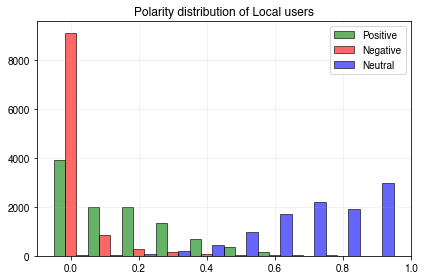

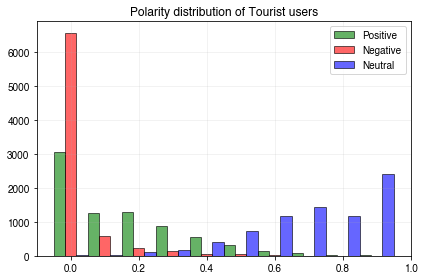

In [144]:
pol_plot(df, "location_within_london")

In [15]:
from IPython.display import Markdown

In [88]:
def pretty_print_row(df, row_indices, color_dict, text_col):
    markdown = ""
    for i in row_indices:
        markdown = add_to_markdown(markdown, "{:-^75}".format(i))
        markdown = add_to_markdown(markdown, df.iloc[i][text_col])
        
        for key in color_dict.keys():
            markdown = add_to_markdown(markdown, df.iloc[i][key], color=color_dict[key])
    return markdown

def add_to_markdown(str_1, str_2, color="black"):
    str_1 = str(str_1)
    str_2 = str(str_2)
    
    if color=="black":
        return str_1 + str_2 + "<br>"
    else:
        return str_1 + "<p style=color:{}>".format(color) + str_2 + "</p>"

In [89]:
def get_high_polarity_tweets(df, quantile=0.9, max_tweets=50):
    polarity_dict = {}
    for polarity in ["pos", "neg"]:
        quantile = df[polarity].quantile(quantile)
        polarity_dict[polarity] = df[polarity].sort_values(ascending=False).loc[df[polarity] > quantile].index[:max_tweets]
    return polarity_dict

In [90]:
high_polarity_tweets = get_high_polarity_tweets(df=df, max_tweets=50)
markdown = pretty_print_row(df=df, row_indices=high_polarity_tweets["pos"], color_dict=legend_dict, text_col="text")
Markdown(markdown)

-----------------------------------15580-----------------------------------<br>@TheSun Classy<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------12047-----------------------------------<br>@work1ngmensclub  cheered https://t.co/ou9i42k5cb<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------17875-----------------------------------<br>Gratitude. https://t.co/sv8AEx7GL5<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------2131------------------------------------<br>@mouthwaite @BlenheimPalace @cescloveslife @realDonaldTrump 
Cool! https://t.co/11fkj7sWhG<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------3805------------------------------------<br>@DJNoreenKhan Lovely @DJNoreenKhan 
@realDonaldTrump https://t.co/NKVma9rlm2<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------2126------------------------------------<br>@salmahayek @realDonaldTrump 
Cool! https://t.co/HJyfBzoNfI<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------12045-----------------------------------<br>@FatWhiteFamily  Cheers https://t.co/MIN39WJ359<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------11000-----------------------------------<br>Lovely<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------1613------------------------------------<br>@Gelderdgary1979 @LUFC @FulhamFC Definitely<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------11045-----------------------------------<br>love @clairo 💖💖 https://t.co/e97ouT4qJF<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------6341------------------------------------<br>Hope ✨ https://t.co/Ex1oRZUtSn<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------10708-----------------------------------<br>@KieranNdl Nice<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------6581------------------------------------<br>Hope. https://t.co/DFRlK8mdAD<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------7475------------------------------------<br>@10DowningStreet @BorisJohnson @realDonaldTrump 
@BorisJohnson Congratulations https://t.co/DX3cSdNTcF<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------9549------------------------------------<br>beauty https://t.co/EVRDBDNYQM<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------9245------------------------------------<br>Focused https://t.co/zzYtdtkyuA<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------9152------------------------------------<br>pretty https://t.co/ydRuSH3Zye<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------4867------------------------------------<br>@realpreityzinta @realDonaldTrump 
cool! https://t.co/lKoXW2WNbv<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------5448------------------------------------<br>Classy https://t.co/8AnPU2MifH<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------13308-----------------------------------<br>Cool https://t.co/FnmKa8CWKD<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------1542------------------------------------<br>Nice @DegenerateFoxUK https://t.co/3QJrf74mWX<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------3070------------------------------------<br>Thriller! https://t.co/kJH6pylVNY<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------17553-----------------------------------<br>thanks @LewisCapaldi https://t.co/21eghK5VFx<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------5022------------------------------------<br>Help<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------13752-----------------------------------<br>@Lloydstevens29 Beautiful<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------22663-----------------------------------<br>@julietmusical Amazing!! https://t.co/eQyKRkYu56<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------23039-----------------------------------<br>Heaven https://t.co/5bOFimGKs9<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------20563-----------------------------------<br>@drjanaway Yes! Yes! YES!<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------17063-----------------------------------<br>Excited!! https://t.co/UZJrqCwFfz<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------7759------------------------------------<br>Pretty https://t.co/wA6rXJFl7F<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------5088------------------------------------<br>breathtaking. @WinterWonderLDN https://t.co/xDhf1bjsbA<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------1779------------------------------------<br>fun fun fun https://t.co/10LU6KDApY<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------7758------------------------------------<br>Pretty https://t.co/wA6rXJFl7F<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------19651-----------------------------------<br>@mseriesMMXIV Thanks<br><p style=color:green>1.0</p><p style=color:red>0.0</p><p style=color:blue>0.0</p>-----------------------------------10510-----------------------------------<br>Lovely Jubbly 👌 @dancafc80 https://t.co/iFFiKyHP01<br><p style=color:green>0.909</p><p style=color:red>0.0</p><p style=color:blue>0.091</p>-----------------------------------3009------------------------------------<br>@thomasgfarrellj @babyleggs727 beautiful thankyou 👌<br><p style=color:green>0.909</p><p style=color:red>0.0</p><p style=color:blue>0.091</p>-----------------------------------14825-----------------------------------<br>Lovely Day 💗 https://t.co/h0LlXsE3xW<br><p style=color:green>0.907</p><p style=color:red>0.0</p><p style=color:blue>0.093</p>-----------------------------------14746-----------------------------------<br>Feeling loved ♥️ https://t.co/A8DSbLUKmA<br><p style=color:green>0.906</p><p style=color:red>0.0</p><p style=color:blue>0.094</p>-----------------------------------12338-----------------------------------<br>365 days 👌👌👌 https://t.co/CvbHkNv3Pp<br><p style=color:green>0.902</p><p style=color:red>0.0</p><p style=color:blue>0.098</p>-----------------------------------17453-----------------------------------<br>@226mf_ Loveyouuuu💗💗💗<br><p style=color:green>0.898</p><p style=color:red>0.0</p><p style=color:blue>0.102</p>-----------------------------------10669-----------------------------------<br>pretty pretty london ✨ https://t.co/3L1mmIogyc<br><p style=color:green>0.897</p><p style=color:red>0.0</p><p style=color:blue>0.103</p>-----------------------------------8669------------------------------------<br>Gorgeous 💛 https://t.co/tDkMwZih9a<br><p style=color:green>0.891</p><p style=color:red>0.0</p><p style=color:blue>0.109</p>-----------------------------------7102------------------------------------<br>smile baby smile :) https://t.co/aVDV52dC6s<br><p style=color:green>0.889</p><p style=color:red>0.0</p><p style=color:blue>0.111</p>-----------------------------------11050-----------------------------------<br>With @GarthTroubadour 

Great pleasure https://t.co/LPS9WL9g9n<br><p style=color:green>0.886</p><p style=color:red>0.0</p><p style=color:blue>0.114</p>-----------------------------------13176-----------------------------------<br>Happy Anniversary gorgeous. https://t.co/NuDIE3t8vV<br><p style=color:green>0.885</p><p style=color:red>0.0</p><p style=color:blue>0.115</p>-----------------------------------19961-----------------------------------<br>Yes! Great name! https://t.co/PoYcSvRl76<br><p style=color:green>0.881</p><p style=color:red>0.0</p><p style=color:blue>0.119</p>-----------------------------------6732------------------------------------<br>✨ Enchanted Eltham ✨ https://t.co/tVL1IDUQs4<br><p style=color:green>0.878</p><p style=color:red>0.0</p><p style=color:blue>0.122</p>-----------------------------------8255------------------------------------<br>Good night xoxo https://t.co/je1yHoJLwo<br><p style=color:green>0.873</p><p style=color:red>0.0</p><p style=color:blue>0.127</p>-----------------------------------18657-----------------------------------<br>happy place. 💙💗 https://t.co/ngkKXjgLP9<br><p style=color:green>0.873</p><p style=color:red>0.0</p><p style=color:blue>0.127</p>------------------------------------153------------------------------------<br>JUSTICE. LIBERTY. SCIENCE. https://t.co/p4OrrZP1Mq<br><p style=color:green>0.872</p><p style=color:red>0.0</p><p style=color:blue>0.128</p>

In [19]:
from scipy.stats import ttest_ind

In [111]:
def print_t_test(df, user_classification_column, **kwargs):
    columns = ["pos", "neg", "neu"]
    colors = ["green", "red", "blue"]
    labels = ["Positive", "Negative", "Neutral"]
    result = ""
    for col, col_name, color in zip([*columns, "compound"], [*labels, "Compound"], [*colors, "Olive"]):
        t_test, p = ttest_ind(df[col].loc[df[user_classification_column] == "local"], df[col].loc[df[user_classification_column] == "tourist"], **kwargs)
        result += f"t-test for <a style=color:{color}><b>{col_name}</b></a> polarity:<br>"
        result += f"t-test statistic: {round(t_test, 2)}<br>p-value: {round(p, 3)}"
        result += "<br><br>"
    return Markdown(result)

In [112]:
print_t_test(df, "location_within_london", equal_var=False)

t-test for <a style=color:green><b>Positive</b></a> polarity:<br>t-test statistic: -1.05<br>p-value: 0.293<br><br>t-test for <a style=color:red><b>Negative</b></a> polarity:<br>t-test statistic: -1.32<br>p-value: 0.188<br><br>t-test for <a style=color:blue><b>Neutral</b></a> polarity:<br>t-test statistic: 1.66<br>p-value: 0.097<br><br>t-test for <a style=color:Olive><b>Compound</b></a> polarity:<br>t-test statistic: 6.1<br>p-value: 0.0<br><br>

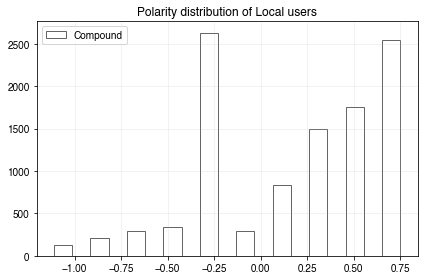

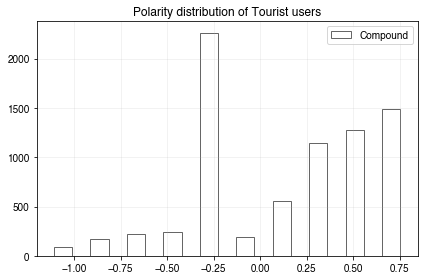

In [79]:
user_groups = ["local", "tourist"]
group_names = ["Local users", "Tourist users"]
user_classification_column = "location_within_london"
for group, group_name in zip(user_groups, group_names):
    dframe = df.loc[df[user_classification_column] == group]
    edgecolor = "black"
    alpha = 0.6
    fig, ax = plt.subplots()
    columns = ["compound"]
    colors = ["white"]
    legend_dict_comp = dict(zip(columns, colors))

    labels = ["Compound"]
    handles = [plt.Rectangle((0,0),1,1, facecolor=legend_dict_comp[column], alpha=alpha, edgecolor=edgecolor) for column in columns]

    for index, (col, color) in enumerate(zip(columns, colors)):
        if index == 0:
            hist_tuple_first = np.histogram(dframe[col])
            width = (hist_tuple_first[1][1] - hist_tuple_first[1][0])/(len(columns)+1)
            ax.bar(hist_tuple_first[1][:-1] - width, hist_tuple_first[0], facecolor=color, alpha=alpha, width=width, edgecolor=edgecolor)
        else:
            hist_tuple = np.histogram(dframe[col], bins=hist_tuple_first[1])
            ax.bar(hist_tuple[1][:-1] + width * (index - 1), hist_tuple[0], facecolor=color, alpha=alpha, width=width, edgecolor=edgecolor)

    plt.legend(handles, labels)
    plt.grid(True, which="both", alpha=0.3, linewidth=0.5)
    plt.title(f"Polarity distribution of {group_name}")
    plt.tight_layout()

From this, it is evident, that the sentiments themselves do differ between tourists and locals, although the cause of this requires further investigation, for example whether a handful of very active users in the locals group leads to a contribution bias that explains the abundance of highly positive compound tweet sentiments.

## TripAdvisor

### 1. Load data

In [43]:
env = dotenv_values()
env["dbname"] = "TripAdvisor"
conn_ta = db.connect(**env)

In [46]:
tripadvisor_sample_query = """
SELECT
    *
FROM
    (
    SELECT
        reviews.id, reviews.title, reviews.rating, reviews.date::date, reviews.full, 
        reviews.user_profile, reviews.attr_id, case when ta_user_classification.class_within_gl then 'local' else 'tourist' end, attractions.geom
    FROM
        reviews
    JOIN
        users
    ON
        users.profile = reviews.user_profile
    JOIN
        attractions
    ON
        reviews.attr_id = attractions.id
    JOIN
        ta_user_classification
    ON
        reviews.user_profile = ta_user_classification.profile
         ) as s 
WHERE
    date BETWEEN SYMMETRIC '2019-11-30' AND '2020-01-01'
"""

In [47]:
df_ta = pd.read_sql(tripadvisor_sample_query, conn_ta)

In [48]:
df_ta

,id,title,rating,date,full,user_profile,attr_id,case,geom
0,732868532,Court dinner,5,2019-12-15,"An amazing venue , full of opulence and ...",/Profile/katrinad947,19041690,tourist,0101000020E61000003D27BD6F7CEDB9BFD0D38041D2C1...
1,733257910,A striking and moving tribute to an icon of ou...,5,2019-12-17,The bust of Nelson Mandela now sits in a corri...,/Profile/richardpre,17326340,local,0101000020E610000025AFCE31207BBDBF8FE1B19FC5C0...
2,732271603,AMAZING!,5,2019-12-12,The best view ever! It’s fantastic! We’re thri...,/Profile/cmlz,15567100,tourist,0101000020E61000008E588B4F0130B6BFB343FCC396C0...
3,730683726,Not a 5* experience,1,2019-12-04,Positives- beautiful view! It’s truly an amazi...,/Profile/14georginal,15567100,tourist,0101000020E61000008E588B4F0130B6BFB343FCC396C0...
4,733574536,Stadium tour,5,2019-12-19,Tommy and harry top job wicked day thanks full...,/Profile/403garethh,14985376,tourist,0101000020E6100000B30C71AC8BDBB0BF8AAE0B3F38CD...
...,...,...,...,...,...,...,...,...,...
3825,731974852,Fantastic day,5,2019-12-10,We had a brilliant day- it was a gift given to...,/Profile/X7517CYangelab,194299,local,0101000020E61000009B1DA9BEF38BC0BF99805F2349C0...
3826,735180650,Pretty Market,5,2019-12-28,Beautiful market \nLots of shopping and food c...,/Profile/RParbhoo,189047,tourist,0101000020E61000000EF7915B936EBFBFCCD0782288C1...
3827,734957020,One of the best spots at London,5,2019-12-27,A great place to see artists...to have a drink...,/Profile/PatriciaNare,189047,tourist,0101000020E61000000EF7915B936EBFBFCCD0782288C1...
3828,734350491,Christmas tidings,3,2019-12-23,Christmas is only a day away and Covent Garden...,/Profile/Museuman,189047,local,0101000020E61000000EF7915B936EBFBFCCD0782288C1...


### 2. Preprocessing

Unlike tweets, TripAdvisor reviews are required to have at least 200 characters, but can be significantly longer. This leads to most reviews being written in a less informal way. Furthermore, TripAdvisor forbids including any URLs, while mentions and hashtags are not supported features on the platform. This makes the preprocessing steps taken for Twitter largely unnecessary.

Furthermore, the VADER SA eliminates the need for preprocessing steps typical to NLP problems, like stemming or lemmatization. Therefore, let's have a look at a review sample and check whether any other preprocessing might be necessary.

In [69]:
np.random.seed(0)
ta_sample = np.random.randint(0, df_ta.shape[0], 10)

In [70]:
for i in ta_sample:
    print(df_ta.iloc[i]["full"])

Booked to see The Man in the White Suit which unfortunately closed early so swapped the tickets for Curtains the replacement. The show itself was quite funny with good acting and some very good tunes.  Jason Manford played the lead role very well.

The theatre is small, (the toilets in particular) but I was surprised the seats we choose (up in the balcony) had such a good view and the seats were comfortable. The bar was average with the usual high theatre price for drinks and there could have been a few more seats and tables.

Would definitely return to see another show at this theatre.
Offers lovely view - bollywood memories - must visit to relive all the scenes from bollywood movies.
Gallery lay out well done, narrative in each room was very informative. Excellent coverage of the different phases of this artist.
I visited the London Eye yesterday and had booked a time slot for the evening so that I could see the London skyline lit up. I booked online and the queue moved fairly quickl

### 3. Sentiment Analysis

In [72]:
def calculate_review_sentiment(series):
    tweet = series["full"]
    sentiment = senti_analyzer.polarity_scores(tweet)
    for key in sentiment.keys():
        series[key] = sentiment[key]
    return series

In [73]:
df_ta = df_ta.apply(calculate_review_sentiment, axis=1)

In [96]:
high_pol_reviews = get_high_polarity_tweets(df_ta, max_tweets=10)
markdown = pretty_print_row(df_ta, high_pol_reviews["neg"], legend_dict, text_col="full")
Markdown(markdown)

-----------------------------------2176------------------------------------<br>Very disappointing. House drinks included with no name spirits, limited food, broken charging points. This is one of the worst lounges I’ve been in and deffo wouldn’t come back.<br><p style=color:green>0.0</p><p style=color:red>0.381</p><p style=color:blue>0.619</p>------------------------------------146------------------------------------<br>Nothing really to say but it’s overcrowded and not sure what the way forward is. But think unfair you pay more for such a poor service.<br><p style=color:green>0.0</p><p style=color:red>0.359</p><p style=color:blue>0.641</p>-----------------------------------3106------------------------------------<br>We visited Hyde Park tk see winter wonderland. It was chaos. No organisation, massive fight broke out and it took 2 hours to get in. Shame as it is such a beautiful place. <br><p style=color:green>0.086</p><p style=color:red>0.318</p><p style=color:blue>0.596</p>-----------------------------------3265------------------------------------<br>This was a great museum. The history of the prison was artfully presented and I can’t believe how much we learned about this horrifying history of torture and mistreatment. Seeing the actual torture devices was fascinating and a bit terrifying too. <br><p style=color:green>0.125</p><p style=color:red>0.316</p><p style=color:blue>0.559</p>------------------------------------447------------------------------------<br>Really, don’t bother ...,,,,,,,,,,,,,,,,,,,,,Seats uncomfortable   Sooooooo bad.  ............ dancing out of time...... tall skinny snowman when film is cute and round......<br><p style=color:green>0.104</p><p style=color:red>0.305</p><p style=color:blue>0.591</p>-----------------------------------3588------------------------------------<br>London underground os old. Trains are old, stations are old. Very narrow, and scaring.

Not the best place to be in case of a Panic Situation.<br><p style=color:green>0.0</p><p style=color:red>0.299</p><p style=color:blue>0.701</p>-----------------------------------1580------------------------------------<br>It is an expensive place to have a nap. Food is mediocre and the choise was underwhelming. But the worst of it was that I had to witness a racist rant coming from a British traveller toward a Muslim family. The staff managed it very poorly, and had the Muslim family removed rather then the racist man who had started the argument. I had to ask the staff to have him removed before anything happened to that racist man.<br><p style=color:green>0.0</p><p style=color:red>0.281</p><p style=color:blue>0.719</p>------------------------------------759------------------------------------<br>The afternoon tea was so bad it's not worth description Service was diabolical The Chef should be sacked terrible food It ruined our day in London I could make a better afternoon tea! Close it down<br><p style=color:green>0.062</p><p style=color:red>0.272</p><p style=color:blue>0.666</p>-----------------------------------1263------------------------------------<br>Very disappointing where have all the market and craft stalls gone replaced with food chains lost its character <br><p style=color:green>0.0</p><p style=color:red>0.266</p><p style=color:blue>0.734</p>-----------------------------------3723------------------------------------<br>Market disappointing - too repetitive ! 
Food stalls are ok and the food we had was hot and filled us up . Poor signage around the park so you struggle to find things. toilets are so disgusting ! No toilet paper and no paper towels. Even after asking an attendant they just shrugged it off . Seems a lot smaller than last year <br><p style=color:green>0.028</p><p style=color:red>0.264</p><p style=color:blue>0.708</p>

0.020066666666666667
0.024166666666666666


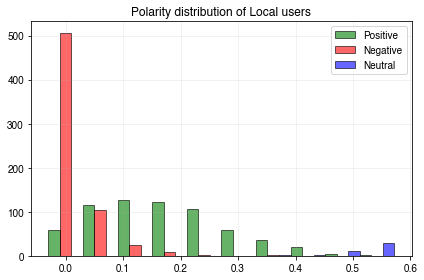

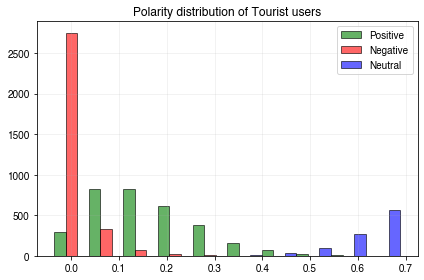

In [146]:
pol_plot(df_ta, "case") # to do: fix x-axis

In [113]:
print_t_test(df_ta, "case", equal_var=False)

t-test for <a style=color:green><b>Positive</b></a> polarity:<br>t-test statistic: 0.27<br>p-value: 0.787<br><br>t-test for <a style=color:red><b>Negative</b></a> polarity:<br>t-test statistic: 1.96<br>p-value: 0.05<br><br>t-test for <a style=color:blue><b>Neutral</b></a> polarity:<br>t-test statistic: -1.18<br>p-value: 0.237<br><br>t-test for <a style=color:Olive><b>Compound</b></a> polarity:<br>t-test statistic: -1.38<br>p-value: 0.167<br><br>

Not surprisingly, the sentiment distributions of Twitter and TripAdvisor are vastly different. Generally, TripAdvisor reviews are more sentiment-laden, which is expected, since they are longer and people use it explicitly to describe experiences.

That being said, there are differences between tourists' and locals' sentiment, but they differ across the two platforms: while on Twitter, a significant difference was found in the compound polarity, while on TripAdvisor the only significant difference was in negative polarity.